### How important is the BC policy quality in the effectiveness of HR-PPO?

In [2]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.policies import load_policy
from utils.config import load_config_nb
# Load config files
from utils.eval import EvaluatePolicy
from utils.sb3.reg_ppo import RegularizedPPO
import glob
import os

sns.set("notebook", font_scale=1.12, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

METRICS_HUMAN_LIKE = ['act_acc', 'accel_val_mae', 'steer_val_mae', 'speed_mae', 'ADE']
METRICS_PERFORMANCE = ['goal_rate', 'off_road', 'collision_rate']

In [3]:
# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
models_config = load_config_nb("model_bc_quality") # Trained models

# Evaluation settings
EVAL_MODE = 'Log-replay'
DATASET = '../data/train_no_tl'

env_config.data_path = DATASET
NUM_EVAL_EPISODES = 50 # Number of episodes to evaluate on
DETERMINISTIC = False 
SELECT_FROM = 50
MAX_CONTROLLED_AGENTS = 200 # All agents are controlled

# Dataset
env_config.data_path = DATASET
test_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
test_eval_files = sorted([os.path.basename(file) for file in test_file_paths])[:SELECT_FROM]

### Helper functions

In [3]:
def calculate_quality(goal_rate, coll_rate, off_road):
    # Calculate the average of the three inputs
    quality_score = (goal_rate + (1 - coll_rate) + (1 - off_road)) / 3
    return quality_score

### Generate dataframes

In [10]:
# Evaluate PPO models
df_ppo = pd.DataFrame()

PPO_BASE_PATH = f"../{models_config.hr_ppo_models_dir_self_play}"

for model_config in models_config.trained_models:
    
    print(f"Evaluating {model_config.hr_ppo_name}...")
    
    # Load policia
    ppo_policy = RegularizedPPO.load(
        f'{PPO_BASE_PATH}/{model_config.hr_ppo_name}'
    )
    
    # Evaluate policy
    ppo_evaluator = EvaluatePolicy(
        env_config=env_config,
        policy=ppo_policy,
        single_agent=True,
        eval_files=test_eval_files,
        deterministic=DETERMINISTIC,
        reg_coef=model_config.reg_weight,
    )
    df_res = ppo_evaluator._get_scores()
            
    # Add identifiers
    df_res['Agent'] = model_config.agent
    df_res['Train agent'] = model_config.train_agent
    df_res['Dataset'] = DATASET
    df_res['Eval mode'] = EVAL_MODE
    df_res['IL policy'] = model_config.il_policy
    df_res['IL policy name'] = model_config.il_policy_name
    
    # Store
    df_ppo = pd.concat([df_ppo, df_res], ignore_index=True)

Evaluating policy_L0.0_IL_0_I1200.zip...


INFO:root:No regularization weight specified, using default PPO.
INFO:root:Using regularization loss: None
INFO:root:
 Evaluating policy on 50 files...
100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Evaluating policy_L0.07_IL_1_I1800.zip...


INFO:root:No regularization weight specified, using default PPO.
INFO:root:Using regularization loss: None
INFO:root:
 Evaluating policy on 50 files...
100%|██████████| 50/50 [00:23<00:00,  2.11it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:Using regularization loss: None
INFO:root:
 Evaluating policy on 50 files...


Evaluating policy_L0.07_IL_50_I2927.zip...


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]
INFO:root:No regularization weight specified, using default PPO.
INFO:root:Using regularization loss: None
INFO:root:
 Evaluating policy on 50 files...


Evaluating policy_L0.07_IL_500_I2600.zip...


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


### Evaluate BC policies

In [11]:
# Evaluate PPO models
df_il = pd.DataFrame()

IL_BASE_PATH = f"../{models_config.bc_models_dir}"

for model_config in models_config.trained_models:
    
    # Load policia
    if model_config.il_policy_name != None:
       
        human_policy = load_policy(
            data_path=IL_BASE_PATH,
            file_name=model_config.il_policy_name, 
        )
        
        # Evaluate policy
        il_evaluator = EvaluatePolicy(
            env_config=env_config,
            policy=human_policy,
            eval_files=test_eval_files,
            single_agent=True,
            deterministic=DETERMINISTIC,
            reg_coef=model_config.reg_weight,
        )
        
        df_res_il = il_evaluator._get_scores()
                
        # Add identifiers
        df_res_il['Agent'] = model_config.agent
        df_res_il['Train agent'] = model_config.train_agent
        df_res_il['Dataset'] = DATASET
        df_res_il['Eval mode'] = EVAL_MODE
        df_res_il['IL policy'] = model_config.il_policy
        df_res_il['IL policy name'] = model_config.il_policy_name
        
        # Store
        df_il = pd.concat([df_il, df_res_il], ignore_index=True)

INFO:root:
 Evaluating policy on 50 files...


100%|██████████| 50/50 [00:06<00:00,  7.20it/s]
INFO:root:
 Evaluating policy on 50 files...
100%|██████████| 50/50 [00:06<00:00,  7.38it/s]
INFO:root:
 Evaluating policy on 50 files...
100%|██████████| 50/50 [00:06<00:00,  7.37it/s]


### Compare

In [6]:
df_il_agg = df_il.groupby(['IL policy'])[METRICS_HUMAN_LIKE+METRICS_PERFORMANCE].mean() 
df_hr_ppo_agg = df_ppo.groupby(['IL policy'])[METRICS_HUMAN_LIKE+METRICS_PERFORMANCE].mean() 

df_hr_ppo_agg.reset_index(inplace=True)
df_il_agg.reset_index(inplace=True)

custom_order = ['0_scenes', '1_scenes', '50_scenes', '200_scenes']

# Convert 'IL policy' column to categorical with custom order
df_il_agg['IL policy'] = pd.Categorical(df_il_agg['IL policy'], categories=custom_order, ordered=True)
df_hr_ppo_agg['IL policy'] = pd.Categorical(df_hr_ppo_agg['IL policy'], categories=custom_order, ordered=True)

df_il_agg['total_coll_rate'] = df_il_agg['collision_rate'] + df_il_agg['off_road']
df_hr_ppo_agg['total_coll_rate'] = df_hr_ppo_agg['collision_rate'] + df_hr_ppo_agg['off_road']

df_hr_ppo_agg['total_coll_rate'] *= 100
df_il_agg['total_coll_rate'] *= 100
df_hr_ppo_agg['goal_rate'] *= 100
df_il_agg['goal_rate'] *= 100

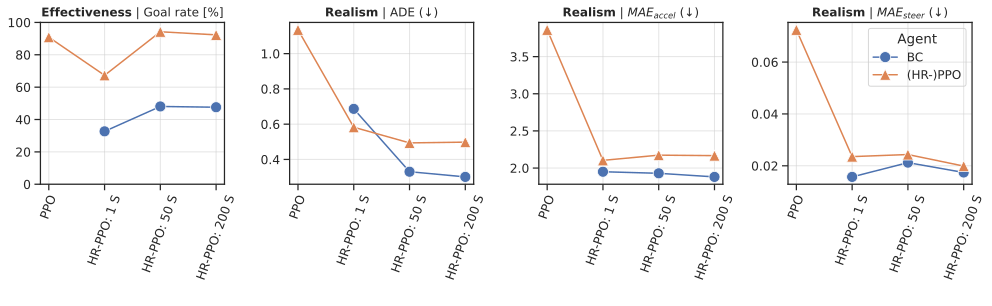

In [7]:
mpl.rcParams["lines.markersize"] = 11

fig, axes = plt.subplots(1, 4, figsize=(14, 4.5), sharex=True,)

# Effectiveness
sns.lineplot(
    data=df_il_agg,
    x='IL policy',
    y='goal_rate',
    marker='o',
    ax=axes[0],
)

sns.lineplot(
    data=df_hr_ppo_agg,
    x='IL policy',
    y='goal_rate',
    marker='^',
    ax=axes[0],
)

# sns.lineplot(
#     data=df_il_agg,
#     x='IL policy',
#     y='total_coll_rate',
#     marker='o',
#     ax=axes[1],
# )

# sns.lineplot(
#     data=df_hr_ppo_agg,
#     x='IL policy',
#     y='total_coll_rate',
#     marker='^',
#     ax=axes[1],
# )
    
# Human-likeness
sns.lineplot(
    data=df_il_agg,
    x='IL policy',
    y='ADE',
    marker='o',
    ax=axes[1],
)

# Human-likeness
sns.lineplot(
    data=df_hr_ppo_agg,
    x='IL policy',
    y='ADE',
    marker='^',
    ax=axes[1],
)

# Human-likeness
sns.lineplot(
    data=df_il_agg,
    x='IL policy',
    y='accel_val_mae',
    marker='o',
    ax=axes[2],
)

# Human-likeness
sns.lineplot(
    data=df_hr_ppo_agg,
    x='IL policy',
    y='accel_val_mae',
    marker='^',
    ax=axes[2],
)

# Human-likeness
sns.lineplot(
    data=df_il_agg,
    x='IL policy',
    y='steer_val_mae',
    marker='o',
    ax=axes[3],
    label='BC',
)

# Human-likeness
sns.lineplot(
    data=df_hr_ppo_agg,
    x='IL policy',
    y='steer_val_mae',
    marker='^',
    ax=axes[3],
    label='(HR-)PPO',
)


axes[0].set_ylim(0, 100)
axes[3].legend(title='Agent', bbox_to_anchor=(1, 1.), loc='upper right', fontsize=12)
axes[2].set_title('Realism (↓ is better)')
axes[3].set_title('Realism (↓ is better)')
axes[0].grid(True, alpha=0.5)
axes[1].grid(True, alpha=0.5)
axes[2].grid(True, alpha=0.5)
axes[3].grid(True, alpha=0.5)
axes[0].set_ylabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[3].set_xlabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')
axes[3].set_title(r'$\bf{Realism}$ | $MAE_{steer}$ (↓)', fontsize=12)
axes[1].set_title(r'$\bf{Realism}$ | ADE (↓)', fontsize=12)
axes[2].set_title(r'$\bf{Realism}$ | $MAE_{accel}$ (↓)', fontsize=12)
axes[0].set_title(r'$\bf{Effectiveness}$ | Goal rate [%]', fontsize=12)
axes[0].tick_params(axis='x', rotation=70)
axes[1].tick_params(axis='x', rotation=70)
axes[2].tick_params(axis='x', rotation=70)
axes[3].tick_params(axis='x', rotation=70)
axes[0].set_xlabel(' ')

axes[0].set_xticks(custom_order, ['PPO', 'HR-PPO: 1 S', 'HR-PPO: 50 S', 'HR-PPO: 200 S'])

plt.tight_layout()
# sns.lineplot(data=df_il_agg, x='IL policy', y='goal_rate', order=[], marker='o');
# sns.lineplot(data=df_hr_ppo_agg, x='IL policy', y='goal_rate', marker='o');

plt.savefig(f'bc_quality.pdf', bbox_inches="tight")

In [8]:
df_il['IL policy'].unique()

array(['1_scenes', '50_scenes', '200_scenes'], dtype=object)

In [9]:
df_il['IL policy'].unique()

array(['1_scenes', '50_scenes', '200_scenes'], dtype=object)